# Esame pratico di Machine Learning Advanced
Questo notebook mostra come costruire un modello di machine learning per prevedere la provenienza di un vino dato i suoi valori chimici.
# Dataset e Obiettivi:
Utilizzeremo il dataset wine recognition dataset, che è un dataset per la classificazione multiclasse.
Il nostro obiettivo è assicurarci che il modello includa almeno un iperparametro da ottimizzare, e valutare le sue performance dopo che ha valutato i valori chimici dei vini "Wine Recognition"
(https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-recognition-dataset)

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    ParameterSampler,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from scipy.stats import chi2, f_oneway, skew
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [ ]:
# Caricamento del dataset (dataset da google.colab)
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wine_recognition = pd.read_csv(
    "/content/drive/MyDrive/S2I/MLAdvanced/wine.csv", encoding="windows-1254", sep=","
)

In [ ]:
# Analisi del dataframe
print("\nValori dataframe:")
print(wine_recognition.shape)


Valori dataframe:
(178, 14)


# Controllo valori nulli
Ora controlliamo per i valori nulli sia in valori assoluti che in percentuale per aiutarci a capire la qualità dei dati


In [47]:
print("\nControllo dei valori nulli\n", wine_recognition.isnull().sum())


Controllo dei valori nulli
 class                           0
Alcohol                         0
Malic_acid                      0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
OD280_OD315_of_diluted_wines    0
Proline                         0
dtype: int64


Non abbiamo valori nulli, ma continuiamo con l'analisi

In [48]:
print("\nInformazioni delle colonne\n")
wine_recognition.info(memory_usage="deep")


Informazioni delle colonne

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic_acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity_of_ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total_phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid_phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color_intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280_OD315_of_diluted_wines  178 n

# Variabili categoriche e numeriche
Come possiamo notare tutte le nostre variabili sono numeriche variando fra float e interi.

In [49]:
print("Elenco delle colonne\n", wine_recognition.head(10))

Elenco delle colonne
    class  Alcohol  Malic_acid   Ash  Alcalinity_of_ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   
5      1    14.20        1.76  2.45               15.2        112   
6      1    14.39        1.87  2.45               14.6         96   
7      1    14.06        2.15  2.61               17.6        121   
8      1    14.83        1.64  2.17               14.0         97   
9      1    13.86        1.35  2.27               16.0         98   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2    

In [ ]:
print("\nValori della colonna 'class'\n", wine_recognition["class"].unique())


Valori della colonna 'class'
 [1 2 3]


In [ ]:
print(
    "\nQuantità di valori all'interno della colonna 'class'\n",
    wine_recognition["class"].value_counts(),
)


Quantità di valori all'interno della colonna 'class'
 class
2    71
1    59
3    48
Name: count, dtype: int64


# Bilanciamento delle classi
Prima di toccare i dati e il nostro dataset, analizziamo le classi e controlliamo se sono presenti tendenze di cui non siamo a conoscenza.

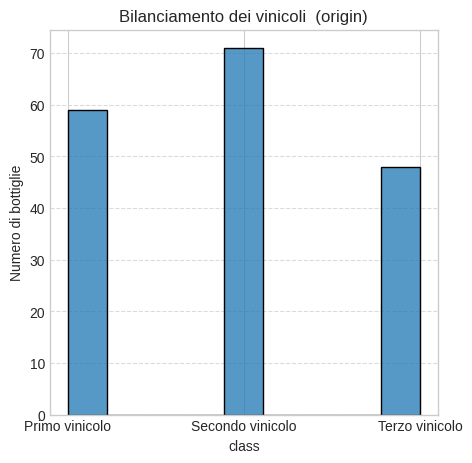

In [ ]:
plt.figure(figsize=(5, 5))  # Imposta le dimensioni del grafico
sns.histplot(wine_recognition, x="class")
plt.title("Bilanciamento dei vinicoli  (origin)")  # Titolo del grafico
plt.ylabel("Numero di bottiglie")  # Etichetta asse Y
plt.xticks(
    ticks=[1, 2, 3], labels=["Primo vinicolo", "Secondo vinicolo", "Terzo vinicolo"]
)  # Etichette personalizzate per l'asse X
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Aggiunge una griglia leggera
plt.show()

In [ ]:
# Valori in percentuale
for category in wine_recognition["class"].unique():
    percentage = (
        len(wine_recognition[wine_recognition["class"] == category])
        / len(wine_recognition)
    ) * 100
    print(
        f"Percentuale di \033[1m{category}\033[0m a confronto con il totale degli elementi: {percentage:.2f}"
    )

Percentuale di 1 a confronto con il totale degli elementi: 33.15
Percentuale di 2 a confronto con il totale degli elementi: 39.89
Percentuale di 3 a confronto con il totale degli elementi: 26.97


Possiamo notare per quanto non estremo un distacco tra la seconda e la terza, rendendo il dataset in parte sbilanciato.

# Definisci le feature (X) e la variabile target (y)


In [ ]:
X = wine_recognition.drop("class", axis=1)
y = wine_recognition["class"]
print(f"\nDimensioni di X:{X.shape}")
print(f"Dimensioni di y:{y.shape}")


Dimensioni di X:(178, 13)
Dimensioni di y:(178,)


# Analisi degli outlier
Un passaggio importante è controllare se sono presenti outlier, controlleremo anche nello specifico fra classe singola


--- Analisi degli Outlier per Classe ---


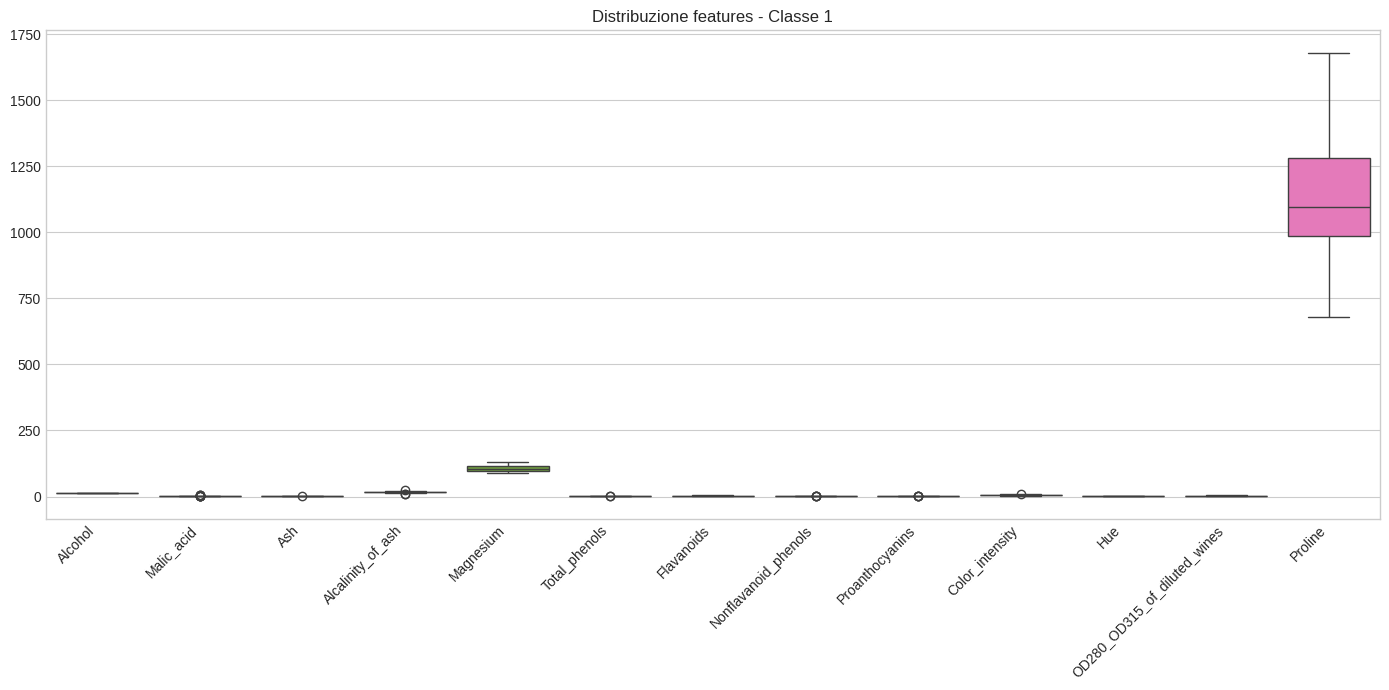

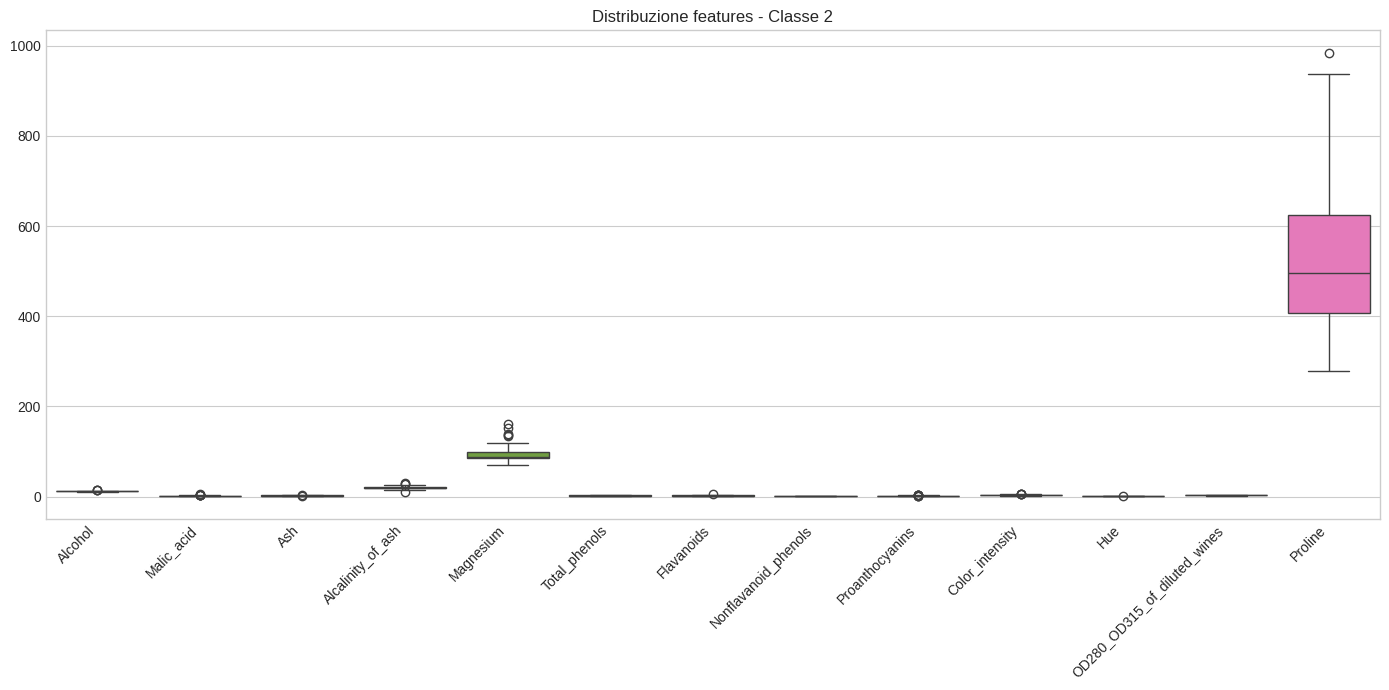

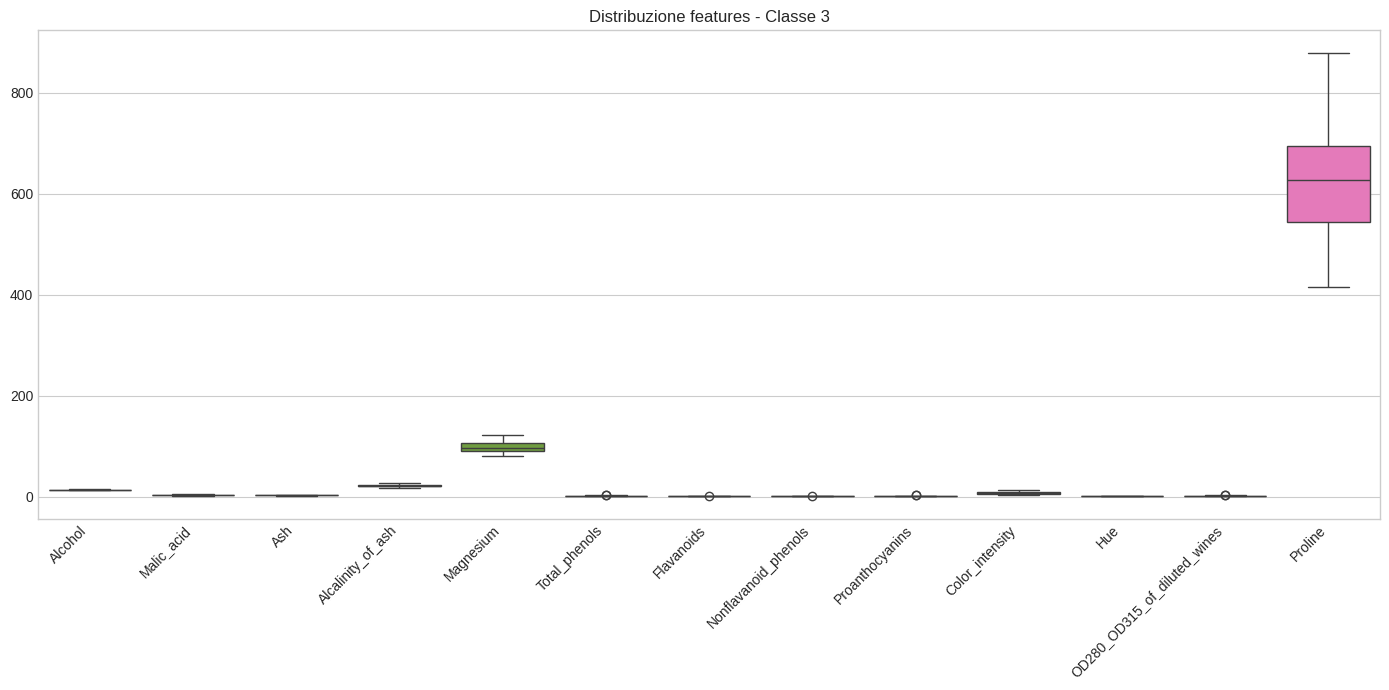

In [ ]:
print("\n--- Analisi degli Outlier per Classe ---")

for class_value in y.unique():
    plt.figure(figsize=(14, 7))
    class_data = X[y == class_value]
    sns.boxplot(data=class_data)
    plt.title(f"Distribuzione features - Classe {class_value}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Per verificare che gli outlier presenti non siano dati solo dalla differenza di "dimensioni" nei valori, faremo un test con la distanza di mahalanobis per trovare una distanza normalizzata delle masse


--- Analisi Multivariata degli Outlier ---
Soglia Mahalanobis: 4.973
Numero di potenziali outlier multivariati: 12


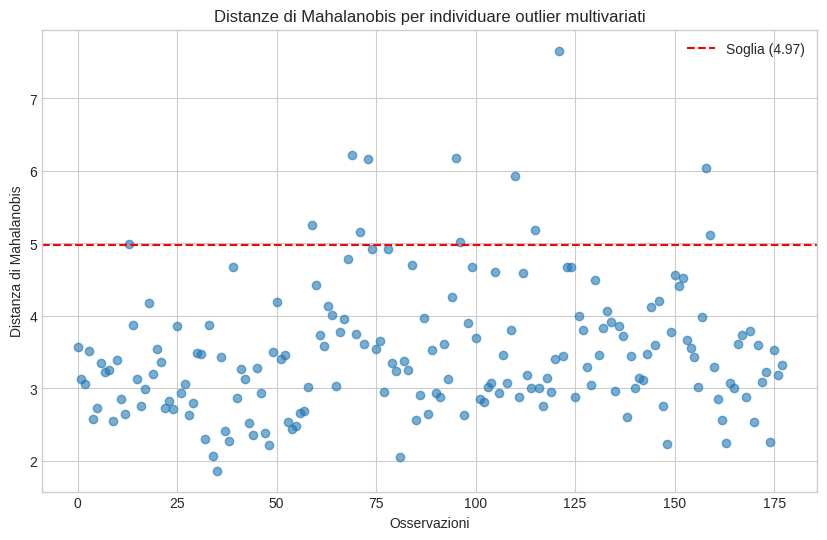

In [ ]:
# Analisi multivariata degli outlier usando il Mahalanobis Distance
print("\n--- Analisi Multivariata degli Outlier ---")

# Calcola la distanza di Mahalanobis per ogni punto
cov_matrix = np.cov(X.values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_vec = np.mean(X.values, axis=0)

# Calcola la distanza per ogni punto
distances = []
for i in range(X.shape[0]):
    delta = X.values[i] - mean_vec
    distance = np.sqrt(delta.dot(inv_cov_matrix).dot(delta.T))
    distances.append(distance)

distances = np.array(distances)

# Trova una soglia basata sulla distribuzione chi-quadrato
threshold = np.sqrt(chi2.ppf(0.975, X.shape[1]))
outliers_mahalanobis = distances > threshold

print(f"Soglia Mahalanobis: {threshold:.3f}")
print(f"Numero di potenziali outlier multivariati: {np.sum(outliers_mahalanobis)}")

# Visualizza le distanze di Mahalanobis
plt.figure(figsize=(10, 6))
plt.scatter(range(len(distances)), distances, alpha=0.6)
plt.axhline(y=threshold, color="r", linestyle="--", label=f"Soglia ({threshold:.2f})")
plt.xlabel("Osservazioni")
plt.ylabel("Distanza di Mahalanobis")
plt.title("Distanze di Mahalanobis per individuare outlier multivariati")
plt.legend()
plt.show()

# Considerazioni
Nel contesto dei vini, dei valori anomali potrebbero rappresentare semplicemente una caratteristica della targhetta, il pregio o la qualità.
Nel nostro caso anche con la presenza di outlier sarebbe ottimo porter verificare se fanno parte di pattern effettivi, cosa che si potrebbe verificare nel tempo quando si avranno piu' dati sotto mano.
Per il momento li manteniamo data la scarsità di dati in nostro possesso, sfruttando a nostro favore il RandomForest che tende ad essere piu robusto riguardo gli outlier.

# Analisi di normalità e asimmetria
Come ultimo controllo verifichiamo che la distribuzione delle feature sono normali(simmetriche), skewed(asimmetriche).
Perché è importante: Molti modelli, inclusa la regressione logistica, che potremmo voler usare come modello base, funzionano meglio con feature distribuite normalmente. Se una feature è fortemente asimmetrica, potrebbe essere utile applicare una trasformazione matematica (come il logaritmo o la radice quadrata) per renderla più simmetrica e migliorare le prestazioni del modello.

In [57]:
print(wine_recognition.columns)
print(wine_recognition.shape)
print(wine_recognition.dtypes)

Index(['class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue',
       'OD280_OD315_of_diluted_wines', 'Proline'],
      dtype='object')
(178, 14)
class                             int64
Alcohol                         float64
Malic_acid                      float64
Ash                             float64
Alcalinity_of_ash               float64
Magnesium                         int64
Total_phenols                   float64
Flavanoids                      float64
Nonflavanoid_phenols            float64
Proanthocyanins                 float64
Color_intensity                 float64
Hue                             float64
OD280_OD315_of_diluted_wines    float64
Proline                           int64
dtype: object


Numero di features: 13
Features: ['Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', 'OD280_OD315_of_diluted_wines', 'Proline']


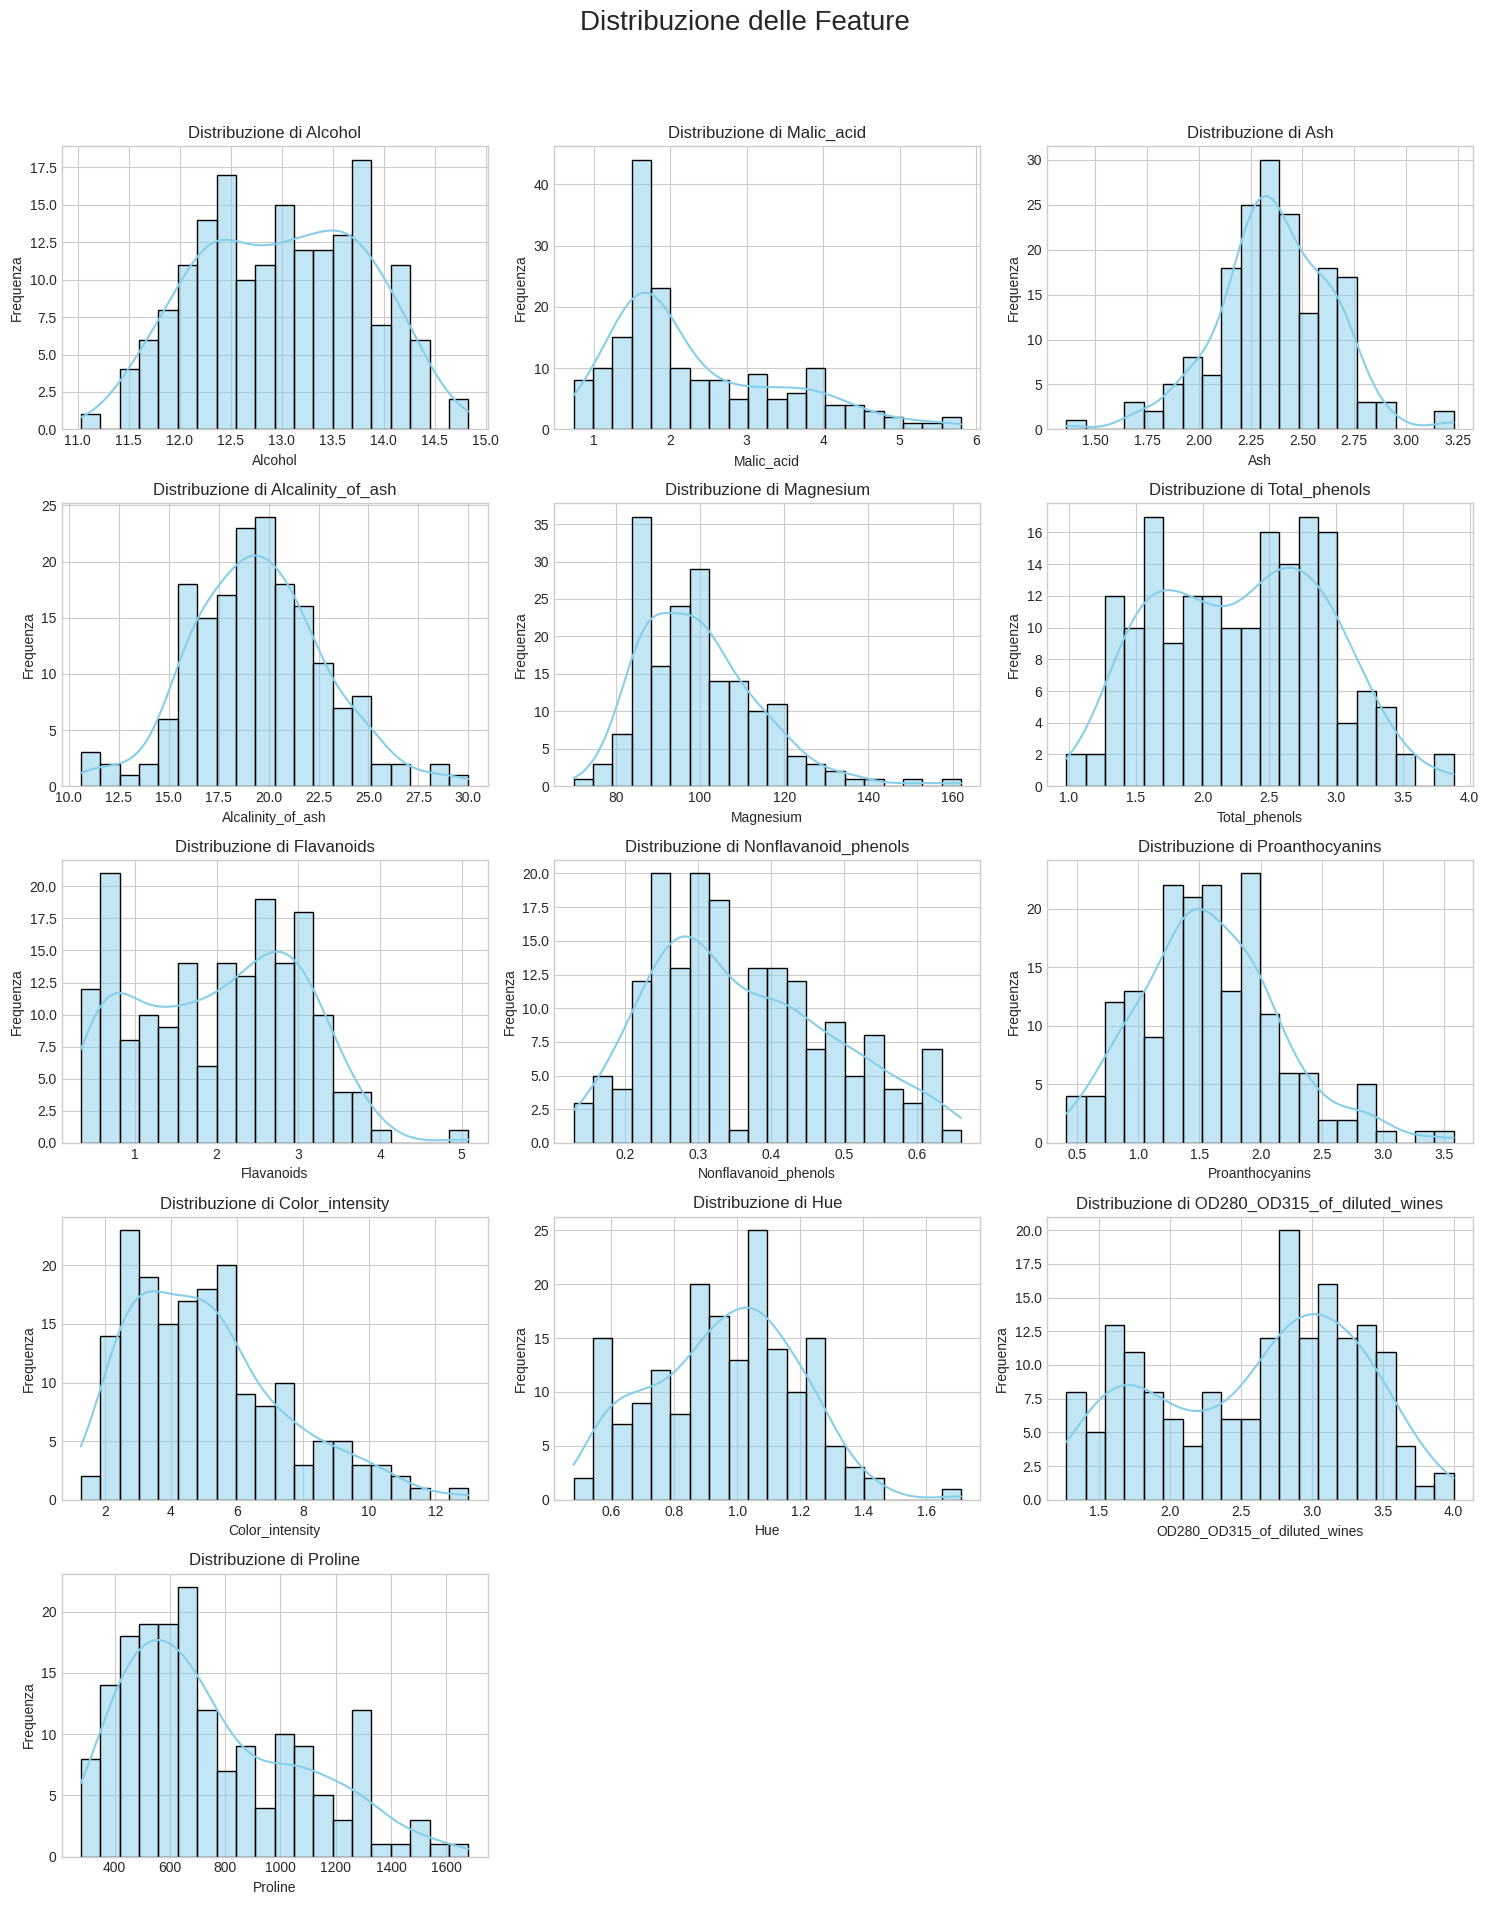

In [ ]:
# Impostazione dello stile per i grafici
plt.style.use("seaborn-v0_8-whitegrid")

# Lista di tutte le feature numeriche da analizzare (escludi la colonna 'class')
features = wine_recognition.select_dtypes(include=["float64", "int64"]).drop(
    columns="class"
)
feature_names = features.columns.tolist()

print(f"Numero di features: {len(feature_names)}")
print(f"Features: {feature_names}")

# Creazione di istogrammi e curve di densità per ogni feature
n_cols = 3  # Numero di colonne per la griglia di grafici
n_rows = (len(feature_names) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
fig.suptitle("Distribuzione delle Feature", fontsize=20)
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(
        data=wine_recognition, x=feature, kde=True, ax=axes[i], bins=20, color="skyblue"
    )
    axes[i].set_title(f"Distribuzione di {feature}", fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel("Frequenza", fontsize=10)

# Nasconde i subplot vuoti se il numero di feature non riempie la griglia
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [59]:
# Calcolo e stampa dello skewness per tutte le feature
skewness_values = wine_recognition[feature_names].apply(skew)
print("\nValori di skewness (asimmetria):")
print(skewness_values.sort_values(ascending=False))


Valori di skewness (asimmetria):
Magnesium                       1.088915
Malic_acid                      1.030869
Color_intensity                 0.861248
Proline                         0.761336
Proanthocyanins                 0.512769
Nonflavanoid_phenols            0.446349
Alcalinity_of_ash               0.211247
Total_phenols                   0.085907
Flavanoids                      0.025129
Hue                             0.020913
Alcohol                        -0.051047
Ash                            -0.175207
OD280_OD315_of_diluted_wines   -0.304690
dtype: float64


I valori di skewness (asimmetria) che vediamo ci danno queste importanti informazioni:
Magnesium e Malic_acid hanno distribuzioni molto sbilanciate verso destra seguite da Color_intensity e Proline, le restanti per quanto sempre assimmetriche sia positiva che negativa stanno in range accettabili stando su un massimo di +-0.5.
Questo ci conferma quello che abbiamo visto in precedenza con gli outlier,

# Modello base
Controlliamo che risultati ci da un modello base in modo da poterLO confrontare con i modelli futuri

In [ ]:
# Crea una copia di X per evitare modifiche accidentali
Xcopy = X.copy()

# Suddividi i dati in set di training e test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7
)

# Inizializza il modello di regressione logistica
# Una Pipeline automatizza il flusso di lavoro:
# - Prima applica lo StandardScaler per normalizzare i dati.
# - Poi addestra il modello di regressione logistica.
# In questo modo, eviti il ConvergenceWarning e la scalatura viene applicata
# in modo corretto sia al set di addestramento che a quello di test.
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "ovr_classifier",
            OneVsRestClassifier(LogisticRegression(solver="lbfgs", max_iter=1000)),
        ),
    ]
)

# 4. Addestramento del modello
# Addestra la pipeline sui dati di training. La scalatura avviene in automatico.
print("Addestramento del modello...")
pipeline.fit(X_train, y_train)
print("Addestramento completato!")

# 5. Valutazione del modello
# Calcola l'accuratezza del modello sul set di test.
test_score = pipeline.score(X_test, y_test)
print(
    f"\nAccuratezza sul set di test (Regressione Logistica Multinomiale): {test_score:.4f}"
)

# Puoi anche fare previsioni e calcolare l'accuratezza manualmente
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza sul set di test: {accuracy:.4f}")

Addestramento del modello...
Addestramento completato!

Accuratezza sul set di test (Regressione Logistica Multinomiale): 0.9556
Accuratezza sul set di test: 0.9556


Questo sarà il nostro punto di partenza.
La scelta di OneVsRestClassifier è stata puramente per precauzione dato la futura rimozione di multi_class in LogisticRegression.
# Discussione sul modello che verrà usato
Ricordiamo che questo sarà solo una base e non continueremo su un LogisticRegression, KNN, SVM perché sfrutteremo Random Forest (non parametrico e modello molto resistente alla skewness) unito al modello out of bag permettendoci di avere il meglio di tutti in un unico modello.
Cosi facendo schiveremo il problema di skewness, presenza di outlier, problemi con la dimenzione del dataset.
Sicuramente i valori di accuratezza sono già molto alti ma dato il nostro dataset preferisco usare un modello piu' adatto alla situazione.

# Correlazione feature e target con base model
Anche se è un passaggio che rifaremo successivamente controlliamo lo stato delle feature esistenti e cerchiamo di capire se sono correlate o meno al target, ovvero le classi.
Testeremo l'Anova e boxplot per avere certezze su modello e feature da selezionare in futuro.

In [ ]:
# Converti la colonna 'class' in tipo categorico per la visualizzazione
wine_recognition["class"] = wine_recognition["class"].astype("category")
print("Prime 5 righe del dataset:")
print(wine_recognition.head())

Prime 5 righe del dataset:
  class  Alcohol  Malic_acid   Ash  Alcalinity_of_ash  Magnesium  \
0     1    14.23        1.71  2.43               15.6        127   
1     1    13.20        1.78  2.14               11.2        100   
2     1    13.16        2.36  2.67               18.6        101   
3     1    14.37        1.95  2.50               16.8        113   
4     1    13.24        2.59  2.87               21.0        118   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_intensity   Hue  OD280_OD315_of_diluted_wines  Proline  
0             5.64  1.04                          3.92     1065  
1    

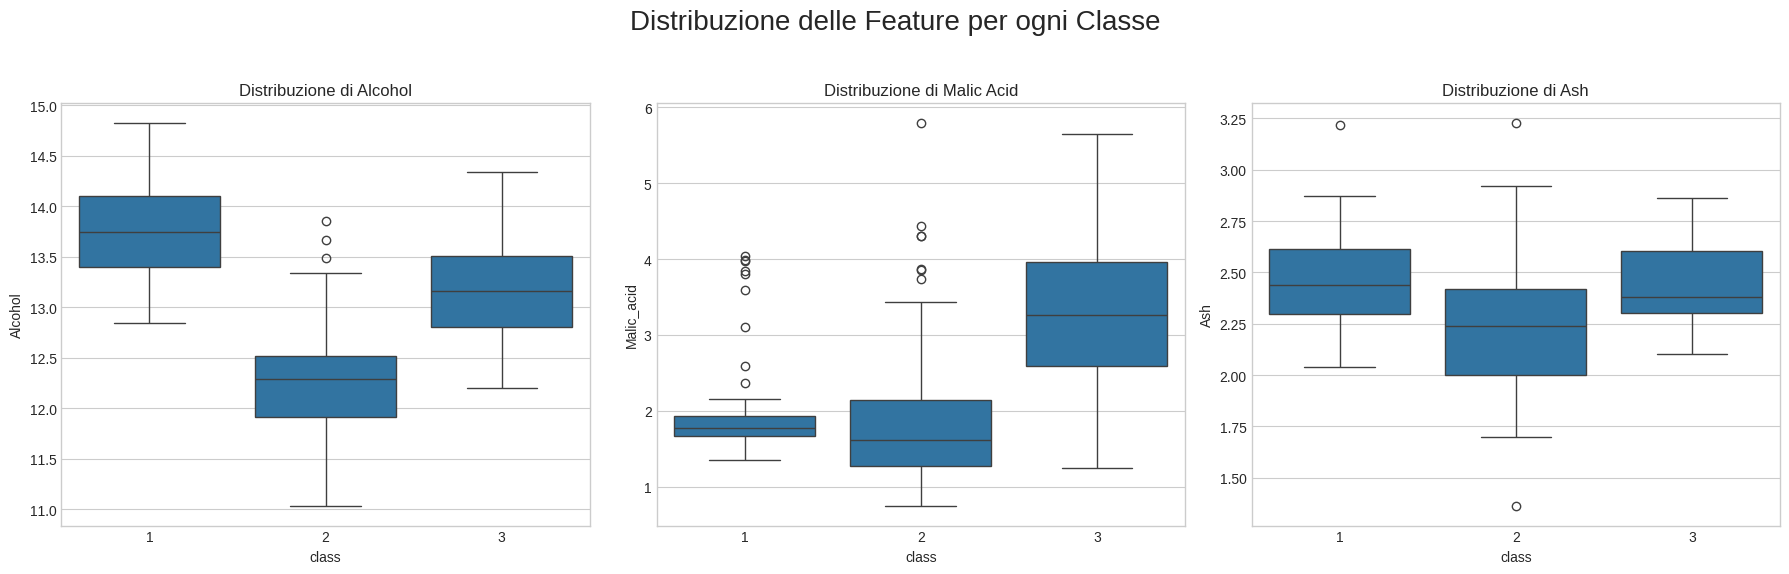

In [ ]:
# --- Analisi con Box Plot ---
# Visualizzazione della distribuzione delle feature per ogni classe
# Un box plot per ciascuna delle prime 3 feature
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Distribuzione delle Feature per ogni Classe", fontsize=20)

sns.boxplot(x="class", y="Alcohol", data=wine_recognition, ax=axes[0])
axes[0].set_title("Distribuzione di Alcohol")

sns.boxplot(x="class", y="Malic_acid", data=wine_recognition, ax=axes[1])
axes[1].set_title("Distribuzione di Malic Acid")

sns.boxplot(x="class", y="Ash", data=wine_recognition, ax=axes[2])
axes[2].set_title("Distribuzione di Ash")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# --- Analisi con ANOVA ---
# Esecuzione del test ANOVA per ogni feature rispetto alla classe
features = [
    "Alcohol",
    "Malic_acid",
    "Ash",
    "Alcalinity_of_ash",
    "Magnesium",
    "Total_phenols",
    "Flavanoids",
    "Nonflavanoid_phenols",
    "Proanthocyanins",
    "Color_intensity",
    "Hue",
    "OD280_OD315_of_diluted_wines",
    "Proline",
]
anova_results = {}

for feature in features:
    # Raggruppa la feature per ogni classe
    groups = [
        wine_recognition[wine_recognition["class"] == c][feature]
        for c in wine_recognition["class"].unique()
    ]

    # Esegue il test ANOVA
    f_statistic, p_value = f_oneway(*groups)
    anova_results[feature] = {"F-Statistic": f_statistic, "P-Value": p_value}

# Stampa i risultati
results_df = pd.DataFrame(anova_results).T.sort_values(by="P-Value")
print("\nRisultati del Test ANOVA:")
print(results_df)


Risultati del Test ANOVA:
                              F-Statistic       P-Value
Flavanoids                     233.925873  3.598586e-50
Proline                        207.920374  5.783168e-47
OD280_OD315_of_diluted_wines   189.972321  1.393105e-44
Alcohol                        135.077624  3.319504e-36
Color_intensity                120.664018  1.162008e-33
Hue                            101.316795  5.917662e-30
Total_phenols                   93.733010  2.137670e-28
Malic_acid                      36.943425  4.127229e-14
Alcalinity_of_ash               35.771637  9.444473e-14
Proanthocyanins                 30.271383  5.125359e-12
Nonflavanoid_phenols            27.575417  3.888041e-11
Ash                             13.312901  4.149968e-06
Magnesium                       12.429584  8.963395e-06


In [ ]:
# --- Giustificazione delle scelte ---
# Interpreta i risultati per giustificare la scelta del modello.
print("\nGiustificazione delle scelte:")
for feature, values in anova_results.items():
    if values["P-Value"] < 0.05:
        print(
            f"\nLa feature '{feature}' ha un P-Value di {values['P-Value']:.4e}, minore di 0.05. Ciò indica che le medie di questa feature sono significativamente diverse tra le classi. Questa è una forte evidenza che la feature è utile per la classificazione."
        )
    else:
        print(
            f"\nLa feature '{feature}' ha un P-Value di {values['P-Value']:.4e}, maggiore di 0.05. Questa feature potrebbe non essere un buon predittore, poiché non c'è una differenza significativa tra le sue medie nelle diverse classi."
        )


Giustificazione delle scelte:

La feature 'Alcohol' ha un P-Value di 3.3195e-36, minore di 0.05. Ciò indica che le medie di questa feature sono significativamente diverse tra le classi. Questa è una forte evidenza che la feature è utile per la classificazione.

La feature 'Malic_acid' ha un P-Value di 4.1272e-14, minore di 0.05. Ciò indica che le medie di questa feature sono significativamente diverse tra le classi. Questa è una forte evidenza che la feature è utile per la classificazione.

La feature 'Ash' ha un P-Value di 4.1500e-06, minore di 0.05. Ciò indica che le medie di questa feature sono significativamente diverse tra le classi. Questa è una forte evidenza che la feature è utile per la classificazione.

La feature 'Alcalinity_of_ash' ha un P-Value di 9.4445e-14, minore di 0.05. Ciò indica che le medie di questa feature sono significativamente diverse tra le classi. Questa è una forte evidenza che la feature è utile per la classificazione.

La feature 'Magnesium' ha un P-Valu

Dai risultati possiamo capire che dati i valori F-Statistic ci sono palesi differenza in importanza per la predizione corretta nel modello prendendo già le prime 3 "Flavanoids", "Proline", "OD280_OD315_of_diluted_wines" che si distaccano piu di tutte.
In contrasto però avendo tutti p-value cosi bassi significa che ogni feature presente contribuisce positivamente.
Per quanto controintuitivo, questo può essere spiegato dal fatto che, si ci sono feature che "pesano" di piu e portano ad una corretta predizione, ma anche che le altre feature collaborano/partecipano in maniera positiva per identificare il corretto vinicolo, questo ovviamente dato dal fatto che certe feature potrebbero essere le particolarità del vino o vinicolo stesso.

# Definizione e scelta degli imputer
Ora possiamo testare le tecniche di imputazione e decidere quale funziona meglio.


Per comodità stiliamo il dizionario degli imputer con tutti quelli principali e piu', cosi da poter coprire una vasta area e non perderci informazioni o casi che potrebbero migliorare il modello completo.

In [ ]:
# Definizione degli imputers
imputers = {
    "Media": SimpleImputer(strategy="mean"),
    "Mediana": SimpleImputer(strategy="median"),
    "Moda": SimpleImputer(strategy="most_frequent"),
    "Costante (0)": SimpleImputer(strategy="constant", fill_value=0),
    "KNN (k=2)": KNNImputer(n_neighbors=2),
    "KNN (k=5)": KNNImputer(n_neighbors=5),
    "KNN (k=10)": KNNImputer(n_neighbors=10),
    "KNN (k=25)": KNNImputer(n_neighbors=25),
    "Iterative (default)": IterativeImputer(random_state=0),
    "Iterative (max_iter=10)": IterativeImputer(max_iter=10, random_state=0),
}

In [ ]:
print("\n--- Ricerca del miglior imputer ---")

# Inizializzazione delle variabili per evitare errori o valori pari a 0
best_imputer = None
best_score = -1.0
imputer_results = {}
oob_score = True
random_state = 42


for name, imputer in imputers.items():
    # Creazione di una copia del dataset per evitare modifiche in-place
    X_imputed = X.copy()

    # Applicazione dell'imputer
    X_imputed.iloc[:, :] = imputer.fit_transform(X_imputed)

    # # Valutazione con CV semplice
    model = RandomForestClassifier(
        n_estimators=100, random_state=random_state, oob_score=oob_score
    )

    cv_score = cross_val_score(model, X_imputed, y, cv=5).mean()

    # Salvataggio del risultato
    imputer_results[name] = cv_score

    # Aggiornamento del miglior imputer
    if cv_score > best_score:
        best_imputer = imputer
        best_score = cv_score

# 2. Applica il miglior imputer
X_imputed = best_imputer.fit_transform(X)
model.fit(X_imputed, y)

# Stampa dei risultati
print("\nConfronto degli imputers:")
for imputer, score in imputer_results.items():
    print(f"{imputer:<25} Accuratezza: {score:.2f}")

# Stampa del miglior imputer
best_imputer_name = max(imputer_results, key=imputer_results.get)
print(
    f"\nMiglior imputer: {best_imputer_name} con Accuratezza: {max(imputer_results.values()):.2f}"
)
print("-------------------------------------------------------")


--- Ricerca del miglior imputer ---

Confronto degli imputers:
Media                     Accuratezza: 0.97
Mediana                   Accuratezza: 0.97
Moda                      Accuratezza: 0.97
Costante (0)              Accuratezza: 0.97
KNN (k=2)                 Accuratezza: 0.97
KNN (k=5)                 Accuratezza: 0.97
KNN (k=10)                Accuratezza: 0.97
KNN (k=25)                Accuratezza: 0.97
Iterative (default)       Accuratezza: 0.97
Iterative (max_iter=10)   Accuratezza: 0.97

Miglior imputer: Media con Accuratezza: 0.97
-------------------------------------------------------


Dai risultati, possiamo vedere che non esiste un imputer che funziona meglio di tutti gli altri in modo assoluto, quindi per mantenere il processo semplice useremo la Media.

# Calcolo e selezione delle feature
Dopo aver trovato il "migliore" imputer passiamo alle feature per poter controllare se ci sono tendenze e/o feature il cui peso è trascurabile

Instanziamo la funzione per calcolare l'importance delle feature del nostro dataset

In [67]:
# Controllo delle feature importances
def plot_feature_importance(model, feature_names, title):
    """
    Visualizza l'importanza delle feature di un modello.
    """
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    top3_features = feature_names[sorted_indices][:3].tolist()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances[sorted_indices], y=feature_names[sorted_indices])
    plt.title(title)
    plt.xlabel("Importanza")
    plt.ylabel("Feature")
    plt.show()

    return top3_features

Qui diamo valori fittizzi a top3_features poiché inizializziamo la variabile all'interno della funzione, per evitare errori di riferimento prima dell'assegnazione faremo cosi.


--- Ricerca Features importanti ---


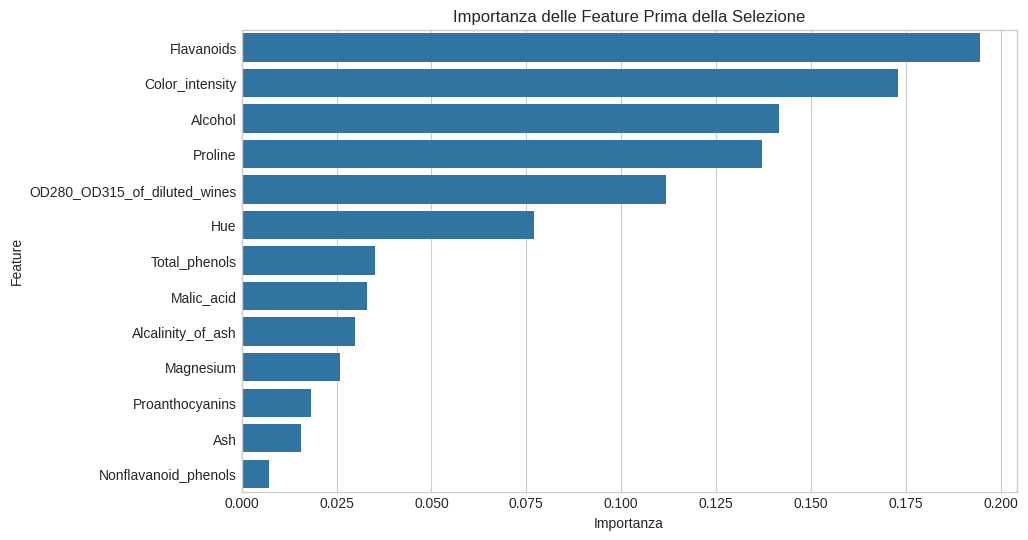

RFECV(cv=5, estimator=RandomForestClassifier(oob_score=True, random_state=42),
      scoring='accuracy')

In [ ]:
print("\n--- Ricerca Features importanti ---")

# Inizializzazione delle variabili per evitare errori o valori pari a 0
top3_features = ["value_A", "value_B", "value_C"]

# We transform it back to DataFrame for easier handling
X_imputed = pd.DataFrame(best_imputer.fit_transform(X), columns=X.columns)

top3_features = plot_feature_importance(
    model, X_imputed.columns, "Importanza delle Feature Prima della Selezione"
)
# Selezione delle feature piu performanti con RFECV
# rfecv_pipeline = get_pipeline(best_classifier_pre_selection)
selector = RFECV(estimator=model, step=1, cv=5, scoring="accuracy")
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_imputed)
selector.fit(X_selected, y)

In [69]:
print(f"\nNumero ottimale di feature: {selector.n_features_}")
print("Ranking delle feature:", selector.ranking_)
print("Feature selezionate:", X.columns[selector.support_].tolist())


Numero ottimale di feature: 13
Ranking delle feature: [1 1 1 1 1 1 1 1 1 1 1 1 1]
Feature selezionate: ['Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', 'OD280_OD315_of_diluted_wines', 'Proline']


# Correlazioni
Una cosa interessante è controllare che correlazioni ci sono fra feature e target, avendone tante controlleremo le prime 3 per importanza utilizzando un violinplot.

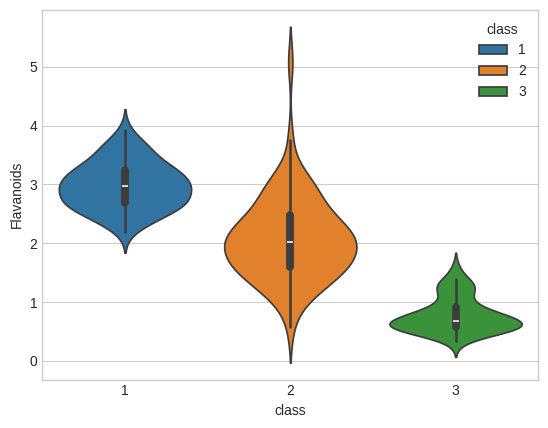

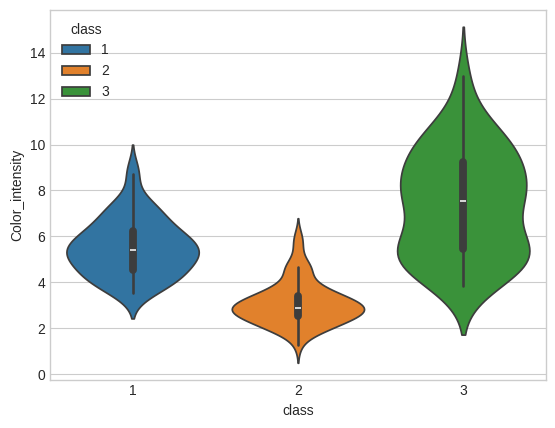

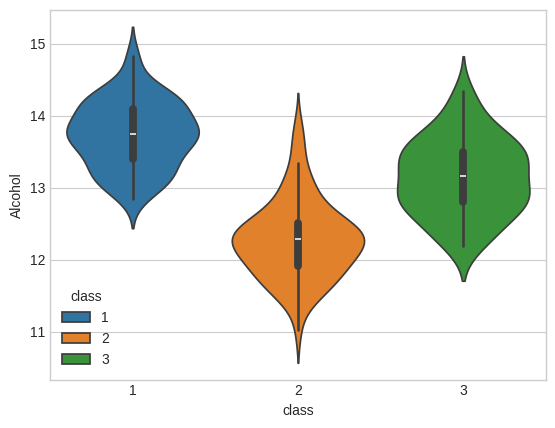

In [ ]:
df = wine_recognition.copy()
# Crea un ciclo per generare un grafico per le top3 feature
for feature in top3_features:
    sns.violinplot(df, x="class", y=df[feature], hue="class")
    plt.show()

Come possiamo vedere i violini ci mostrano:
1) Flavanoids, nella prima e terza classe notiamo che per quanto in range diversi tendono a stare in una loro zona definita mentre la seconda classe ha un range che prende tutto il grafico.
2) Color_intensity, qui invece la similarità è fra le prime 2 classi, con la terzsa che ha un range più ampio ma bello pieno e non concentrato solo al centro.
3) Alcohol, qui tendono a stare tutte nei loro range concentrati in una zona ben definita, con una leggera varianza nella seconda.

Come costante notiamo che la tendenza centrale in tutti i grafici e classi è centrale con un eccezzione nel secondo terza classe dove troviamo 2 "concentrazioni" di dati.
Come ne abbiamo parlato prima questi dati comunque li dobbiamo prendere con la pinza poiché potrebbero essere semplicemente il modo in cui vengono creati i vini.

# Ottimizzazione parametri utilizzando oob
Abbiamo trovato imputer, feature, ora calcolaliamo i parametri che meglio si addicono al modello.
In oltre utilizzeremo un out of bag per avere un maggiore quantitativo di dati su cui lavorare, cosa che purtroppo il train_test non ci permette di fare dato il dataset molto ristretto.
Sfrutteremo successivamente i valori out of bag per testare il modello con valori non utilizzati nel train.

Prima di lavorare inizializziamo il dizionario dei parametri.
La mia scelta iniziale è quella di usare e copreri i parametri più influenti, un opzione sarebbe aggiungere altri parametri come max_features per raffinare ulteriormente la ricerca, ma ritengo sia importante non esagerare per non rendere l'ottimizzazione troppo complessa e dispendiosa in termini di tempo.
Inoltre è un passaggio che comunque facciamo per verificarne l'importanza e farci delle opinioni riguardo alla feature in possesso.

In [ ]:
# Definizione dei parametri da ottimizzare
param_dist = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [ ]:
print("\n--- Ricerca dei migliori iperparametri tramite OOB ---")

# Inizializzazione delle variabili per evitare errori o valori pari a 0
best_oob_value = -1.0
best_params = {}
best_model = None
n_iter = 100  # Numero di combinazioni di iperparametri da testare
params = None


param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
print("\nInizio la ricerca dei migliori iperparametri con validazione OOB...")
for params in param_list:
    # 1. Inizializza il modello con la combinazione di iperparametri corrente
    model_rfc = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"],
        min_samples_leaf=params["min_samples_leaf"],
        oob_score=oob_score,
        random_state=random_state,
    )

    # 2. Addestramento su TUTTO il dataset per calcolare lo score OOB
    model_rfc.fit(X_selected, y)

    # 3. Ottenere il punteggio OOB
    oob_value = model_rfc.oob_score_

    # 4. Confronta e salva i risultati migliori
    if oob_value > best_oob_value:
        best_oob_value = oob_value
        best_params = params
        best_model = model_rfc


--- Ricerca dei migliori iperparametri tramite OOB ---

Inizio la ricerca dei migliori iperparametri con validazione OOB...


In [73]:
print(f"Testati i parametri: {params} -> Punteggio OOB: {oob_value:.4f}")
print("\n--- Risultati Finali della Ricerca ---")
print(f"Miglior Punteggio OOB: {best_oob_value:.4f}")
print(f"Migliori Parametri Trovati: {best_params}")

Testati i parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30} -> Punteggio OOB: 0.9775

--- Risultati Finali della Ricerca ---
Miglior Punteggio OOB: 0.9888
Migliori Parametri Trovati: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


Ci sta poco da aggiungere qui, passiamo alla creazione del modello finale

# Ri-Creazione di un nuovo set di dati con solo le feature selezionate

In [74]:
print("\n--- Valutazione modello Finale ---")


final_classifier = RandomForestClassifier(
    **best_params,  # Usa i migliori parametri trovati
    random_state=random_state,
    oob_score=oob_score,
    n_jobs=-1
)


--- Valutazione modello Finale ---


# CREA LA PIPELINE FINALE con i migliori componenti
infiliamo i valori migliori in una pipeline che potremo richiamare con piu facilità

In [ ]:
final_pipeline = Pipeline(
    [
        ("imputer", best_imputer),  # Miglior imputer trovato
        ("scaler", StandardScaler()),  # Scaling
        ("classifier", final_classifier),  # Miglior modello trovato
    ]
)

# Valutazione dei dati
final_scores = cross_val_score(final_pipeline, X, y, cv=5, n_jobs=-1)
print(f"CV Accuracy finale: {final_scores.mean():.4f} (±{final_scores.std():.4f})")

# ADDESTRA il modello finale su TUTTI i dati
print("\n--- Addestramento Modello Finale ---")
final_model = final_pipeline.fit(X, y)

# ESTRAI le informazioni importanti
classifier = final_model.named_steps["classifier"]

CV Accuracy finale: 0.9610 (±0.0221)

--- Addestramento Modello Finale ---


In [76]:
print(f"OOB Score finale: {classifier.oob_score_:.4f}")

OOB Score finale: 0.9888


Sarà una cosa su cui ripasseremo successivamente, ma possiamo vedere come il valore di OOB non è salito, ma comunque avendo già un valori molto alto di partenza ora possiamo essere piu' tranquilli avendo fatto i controlli necessari che serviranno anche per il futuro quando avremo maggiore quantità di dati, considerando magari di passare ad un train_test.

# Generazione della confusion matrix
Per avere una visualizzazione migliore al posto di scritte e basta stampiamo delle confusion matrix.


--- Matrice di Confusione ---


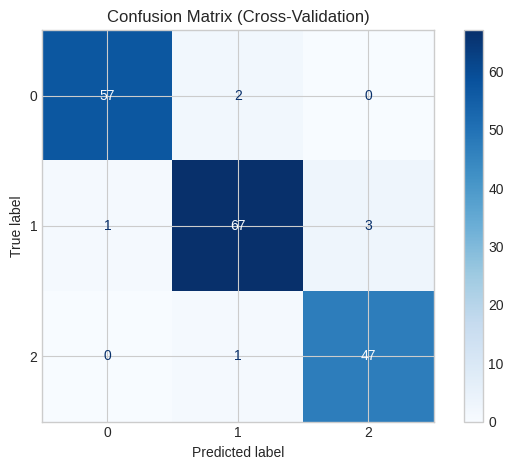

In [ ]:
print("\n--- Matrice di Confusione ---")

# Ottieni predictions con cross-validation
y_pred_cv = cross_val_predict(final_pipeline, X, y, cv=5, n_jobs=-1)

# Calcola confusion matrix
cm = confusion_matrix(y, y_pred_cv)

# Confusion Matrix normale
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Cross-Validation)")
plt.tight_layout()
plt.show()

In [78]:
# METRICHE DETTAGLIATE
print("\n--- Classification Report ---")
print(classification_report(y, y_pred_cv))


--- Classification Report ---
              precision    recall  f1-score   support

           1       0.98      0.97      0.97        59
           2       0.96      0.94      0.95        71
           3       0.94      0.98      0.96        48

    accuracy                           0.96       178
   macro avg       0.96      0.96      0.96       178
weighted avg       0.96      0.96      0.96       178



# RIASSUNTO FINALE

In [79]:
print("\n=== RIASSUNTO FINALE ===")
print(f"Accuracy CV: {final_scores.mean():.4f}")
print(f"OOB Score: {classifier.oob_score_:.4f}")
print(f"\nNumero feature: {selector.n_features_}")
print("Feature:", X.columns[selector.support_].tolist())


=== RIASSUNTO FINALE ===
Accuracy CV: 0.9610
OOB Score: 0.9888

Numero feature: 13
Feature: ['Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', 'OD280_OD315_of_diluted_wines', 'Proline']
